# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

<ErrorbarContainer object of 3 artists>

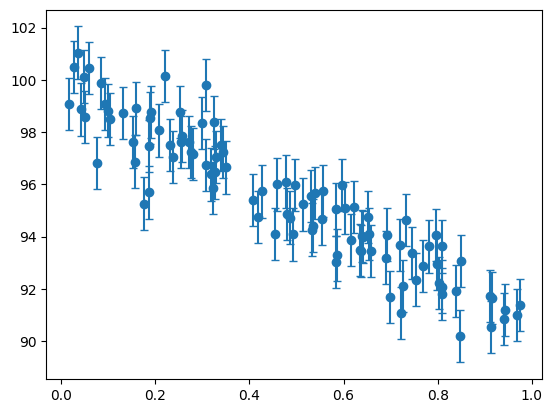

In [20]:
m = -9.8
b= 100
sigma = 1.
N = 100
numbers = np.random.rand(100) 



#plt.plot(numbers, numbers*m+b + np.random.normal(loc=0,scale=sigma,size=N))

plt.errorbar(numbers, numbers*m+b + np.random.normal(loc=0,scale=sigma,size=N), yerr=sigma, fmt="o", capsize=3)


## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [28]:
scale = 50
m_min = m - scale
m_max = m + scale
b_min = b - scale
b_max = b + scale

In [29]:
def log_prior(theta):
    if theta[0]>m_min and theta[0]<m_max and theta[1]>b_min and theta[1]<b_max:
        #case where probability = 1
        ln_prior = 0.
    else:
        #case when probability = 0
        ln_prior = -np.inf
    return ln_prior

def log_likelihood(theta, x, y, dy):
    sum1 = 0
    for i in range(N):
        sum1 += (-0.5)*(np.log(2*np.pi*dy**2) + ((y - (x*theta[0] + theta[1]))/dy)**2)
    return sum1
    
def log_posterior(theta, x, y, dy):
    ans = log_likelihood(theta, x, y, dy) + log_prior(theta)
    return ans

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [30]:
n_walkers = 100
n_params =  2
args =  3

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [65]:
m_random = m_min + np.random.rand(1)*(m_max - m_min)
b_random = b_min + np.random.rand(1)*(b_max - b_min)

rand_array = np.random.rand(2, n_walkers)

intial guesses = 

#intial guesses = 

#initial_guesses =  np.array([[],[]])
#for i in range(n_walkers):
#    intial_guesses = np.append(initial_guesses, m_min + np.random.rand(1)*(m_max - m_min))
#    #initial_guesses[1].append(b_min + np.random.rand(1)*(b_max - b_min))


#random[0], b_random[0]
#print(initial_guesses)

[[0.08913754 0.7892679  0.25783899 0.99170727 0.40212576 0.22972438
  0.17694997 0.16968937 0.68963448 0.03206451 0.88343609 0.34730523
  0.71707094 0.01174262 0.80153884 0.08796243 0.43473531 0.83519522
  0.30575927 0.90437806 0.00957914 0.44384823 0.75927533 0.33919933
  0.14495354 0.36241393 0.18878985 0.32264931 0.51040024 0.39963461
  0.65083266 0.05294032 0.00126298 0.38498839 0.92310583 0.00256053
  0.32813604 0.69315429 0.91825834 0.60748834 0.05459274 0.98104804
  0.98137788 0.98584516 0.8468037  0.21804261 0.4198007  0.2264028
  0.23719482 0.9988596  0.86206593 0.0060587  0.60323389 0.89134937
  0.37800457 0.6747939  0.4778601  0.97449681 0.39401474 0.63250901
  0.93340526 0.30182622 0.41619783 0.57677367 0.20953925 0.39057095
  0.29612412 0.38676379 0.48240384 0.71133334 0.74071661 0.56870722
  0.06616869 0.46455765 0.76225349 0.04102803 0.45401173 0.12154104
  0.07359345 0.0446419  0.52046683 0.81826813 0.79776714 0.21980364
  0.754871   0.95993271 0.20811886 0.38029168 0.9

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [60]:
steps = 1000

sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood, args)

sampler.run_mcmc(initial_guesses, steps)

ValueError: incompatible input dimensions (1, 2)

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

In [ ]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    plt.figure()
    plt.plot(  # complete
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')

    plt.figure()
    plt.plot(  # complete
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

In [ ]:
n_burn =  # complete
chain_plots(  # complete
chain_plots(  # complete

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

In [ ]:
# complete

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

In [ ]:
plt.figure()
# complete

plt.figure()
# complete

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [ ]:
# complete
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

# complete
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

In [ ]:
corner.corner(  # complete

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.